# Univariate LSTM

By Nida Copty, India Tory, Emily Nguyen, Thomas Nguyen

As a baseline model for the time-series LSTM, we have built a model using only one feature: the time-series univariate LSTM. This model is built on only looking at the output feature (Occupancy rates of the shelters) and all other features are discarded. Due to the fact that only 1 feature is being looked at, all shelters' data will be combined into a singular dataset: the city wide occupancy rates dataset.

### Imports

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy as dc
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import random

### Dataset Load

In [ ]:
#Occupancy Rate (Output Data):
data_23 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv"
data_22 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv"
data_21 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv"
data_24 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Daily shelter overnight occupancy.csv"
links = [data_24, data_23, data_22, data_21]

#Weather Data
data_w_23 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv"
data_w_24 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv"
data_w_22 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2022_P1D.csv"
data_w_21 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2021_P1D.csv"
links_weather = [data_w_24, data_w_23, data_w_22, data_w_21]

#Housing
data_housing = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Housing.csv"

#Crisis helpline
data_crisis = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Persons_in_Crisis_Calls_for_Service_Attended_Open_Data.csv"


Class to read and report on errors when reading csv files.

In [ ]:
def load_csv_to_pandas(file_path):
    try:
        # Load CSV file into a pandas data_23Frame
        df = pd.read_csv(file_path, header=0, low_memory=False, encoding='unicode_escape')
        print("Number of rows in the dataFrame:", file_path, len(df))
        return df
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except Exception as e:
        print("An error occurred:", str(e))
        return None

This function below is to convert all the datasets of different features into a singular panda dataframes and also a hashmap containing individual shelter datas.

In [ ]:
def loadData(output_data, weather_data, housing, crisis):

    #-------Output Data-------#
    #Loading up the links to the output dataset
    for i in range(len(output_data)):
        output_data[i] = load_csv_to_pandas(output_data[i])

    #Dropping irrelevant columns for output datasets
    for i in range(len(output_data)):
        #print(output_data[i])
        output_data[i] = output_data[i].drop(columns = ['_id', 'ORGANIZATION_ID', 'SHELTER_ID', 'LOCATION_ID', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME', 'SECTOR', 'PROGRAM_MODEL','OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'SERVICE_USER_COUNT', 'CAPACITY_FUNDING_BED', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'CAPACITY_FUNDING_ROOM', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS'])
        output_data[i]['OCCUPANCY_DATE'] = output_data[i]['OCCUPANCY_DATE']
        output_data[i]['OCCUPANCY_DATE'] =  pd.to_datetime(output_data[i]['OCCUPANCY_DATE'], format='%Y-%m-%d')

    #Joining the Output data together
    big_data = output_data[0]
    for i in range(1,len(output_data)):
        big_data = pd.concat([big_data, output_data[i]], ignore_index = True)

    #Determine the max and min date in the dataset to create a date vector to fill out empty values
    max_date = big_data['OCCUPANCY_DATE'].max()
    min_date = big_data['OCCUPANCY_DATE'].min()
    date_range = pd.date_range(start=min_date, end=max_date, freq = 'D')
    date_df = pd.DataFrame({'OCCUPANCY_DATE': date_range})

    #-------Weather Data-------#

    #loading up the links to the weather dataset
    for i in range(len(weather_data)):
        weather_data[i] = load_csv_to_pandas(weather_data[i])

    #Dropping irrelevant columns for weather datasets
    for i in range(len(weather_data)):
        weather_data[i] = weather_data[i].drop(columns = ['ï»¿"Longitude (x)"', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days Flag', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag',
        'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'])
        weather_data[i]['Date/Time'] = weather_data[i]['Date/Time'].astype(str)
        weather_data[i]['Date/Time'] = pd.to_datetime(weather_data[i]['Date/Time'])

    #Joining the Weather data together
    big_weather = weather_data[0]
    for i in range(1, len(weather_data)):
        big_weather = pd.concat([big_weather, weather_data[i]], ignore_index = True)

    #Cut down all data with dates that is bigger than the biggest date and smaller than the smallest date with an output
    big_weather = big_weather[big_weather['Date/Time'] <= max_date]
    big_weather = big_weather[big_weather['Date/Time'] >= min_date]

    #Fill out datasets' entries w no data w 0
    big_weather = big_weather.fillna(0)

    #Changing non output dataset's date column to 'OCCUPANCY_DATE'
    big_weather = big_weather.rename(columns = {'Date/Time': 'OCCUPANCY_DATE'})

    #-------Housing Data-------#

    #loading up housing data
    housing = load_csv_to_pandas(housing)

    #Dropping irrelevant columns for housing dataset
    housing = housing[housing['GEO'] == 'Toronto, Ontario']
    housing = housing[housing['New housing price indexes'] == 'Total (house and land)']
    housing = housing.drop(columns = ['GEO', 'DGUID', 'New housing price indexes', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'])
    housing = housing.rename(columns = {housing.columns[0]: 'OCCUPANCY_DATE'})
    housing["OCCUPANCY_DATE"] = pd.to_datetime(housing["OCCUPANCY_DATE"])
    housing = housing[housing["OCCUPANCY_DATE"] >= min_date]
    housing = housing[housing["OCCUPANCY_DATE"] <= max_date].reset_index(drop=True)
    housing = pd.merge(housing, date_df, on = 'OCCUPANCY_DATE', how = 'outer')
    housing = housing.sort_values(by='OCCUPANCY_DATE').reset_index(drop=True)
    housing = housing.ffill()

    #-------Crisis Data-------#

    #Loading the crisis dataset
    crisis = load_csv_to_pandas(crisis)

    #Analyize Data
    crisis = crisis.drop(columns = ['ï»¿OBJECTID', 'EVENT_ID', 'EVENT_YEAR', 'EVENT_MONTH', 'EVENT_DOW', 'EVENT_HOUR', 'DIVISION', 'OCCURRENCE_CREATED', 'APPREHENSION_MADE', 'MCIT_ATTEND', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140'])
    crisis = crisis.rename(columns = {'EVENT_DATE': 'OCCUPANCY_DATE'})
    crisis = crisis.groupby(['OCCUPANCY_DATE', 'EVENT_TYPE']).size().unstack(fill_value=0)
    crisis.reset_index(inplace=True)
    crisis = crisis.rename_axis(None, axis=1)
    crisis['OCCUPANCY_DATE'] = pd.to_datetime(crisis['OCCUPANCY_DATE']).dt.date
    crisis['OCCUPANCY_DATE'] = pd.to_datetime(crisis['OCCUPANCY_DATE'])
    crisis = crisis[crisis["OCCUPANCY_DATE"] >= min_date]
    crisis = crisis[crisis["OCCUPANCY_DATE"] <= max_date]
    crisis = pd.merge(date_df, crisis, on='OCCUPANCY_DATE', how='left')

    #-------Final Data Prep-------#

    #Merge the datasets together through date
    big_data = pd.merge(big_data, big_weather, on = 'OCCUPANCY_DATE', how = 'inner')
    big_data = pd.merge(big_data, housing, on = 'OCCUPANCY_DATE', how = 'inner')
    big_data = pd.merge(big_data, crisis, on = 'OCCUPANCY_DATE', how = 'inner')

    big_data = big_data.sort_values(by='OCCUPANCY_DATE')

    #Placing the bed and room occupancy column last
    room_occupancy = big_data.pop('OCCUPANCY_RATE_ROOMS')
    bed_occupancy = big_data.pop('OCCUPANCY_RATE_BEDS')
    big_data['OCCUPANCY_RATE_BEDS'] = bed_occupancy
    big_data['OCCUPANCY_RATE_ROOMS'] = room_occupancy

    grouped_data = big_data.groupby('PROGRAM_ID')
    shelter_data_frames = {}
    for shelter_id, shelter_group in grouped_data:
        shelter_data_frames[shelter_id] = shelter_group
        shelter_data_frames[shelter_id]['OCCUPANCY_DATE'] = pd.to_datetime(shelter_data_frames[shelter_id]['OCCUPANCY_DATE'])

    big_data.reset_index(inplace=True)
    big_data = big_data.drop(columns = ['index'])

    return big_data, shelter_data_frames

Running the function to get the dataframe and hashmap

In [ ]:
dataframe, iso_data = loadData(links.copy(), links_weather.copy(), data_housing, data_crisis)

Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Daily shelter overnight occupancy.csv 11459
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv 48345
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv 49478
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv 50944
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv 366
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv 365
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI 

The dataframe above contains every single data points of every shelters from 2021 to 2024. Inorder to get a trainable dataset for the univariate model, we will have to combine the data of everysingle shelters together into one big city wide occupancy rates. This function below will achieve that target.

In [ ]:
def merge_Shelters_Data(df):

    df = df.drop(columns = ['ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'PROGRAM_ID', 'CAPACITY_TYPE', 'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'])
    grouped_capacity = df.groupby('OCCUPANCY_DATE')[['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM']].sum()
    grouped_occupied = df.groupby('OCCUPANCY_DATE')[['OCCUPIED_BEDS', 'OCCUPIED_ROOMS']].sum()

    df = df.merge(grouped_capacity, on='OCCUPANCY_DATE', suffixes=('', '_TOTAL_CAPACITY'))
    df = df.merge(grouped_occupied, on='OCCUPANCY_DATE', suffixes=('', '_TOTAL_OCCUPIED'))
    df = df.drop(columns = ['CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM', 'OCCUPIED_BEDS', 'OCCUPIED_ROOMS'])
    df = df.drop_duplicates()

    df['TOTAL_OCCUPIED'] = df['OCCUPIED_BEDS_TOTAL_OCCUPIED'] + df['OCCUPIED_ROOMS_TOTAL_OCCUPIED']
    df['TOTAL_CAPACITY'] = df['CAPACITY_ACTUAL_BED_TOTAL_CAPACITY'] + df['CAPACITY_ACTUAL_ROOM_TOTAL_CAPACITY']
    df['OCCUPIED_PERCENTAGE'] = 100 * df['TOTAL_OCCUPIED']/df['TOTAL_CAPACITY']
    df = df.drop(columns = ['CAPACITY_ACTUAL_BED_TOTAL_CAPACITY', 'CAPACITY_ACTUAL_ROOM_TOTAL_CAPACITY', 'OCCUPIED_BEDS_TOTAL_OCCUPIED', 'OCCUPIED_ROOMS_TOTAL_OCCUPIED', 'TOTAL_CAPACITY', 'TOTAL_OCCUPIED'])
    return df

Running the function above will get us the combined Toronto wide occupancy rates of all shelters

In [ ]:
df = merge_Shelters_Data(dataframe)

### Convert Dataset to Dataloader

With the proper dataframe, we will need to convert the dataset into a timeseries and then dataloader to feed into the model for training

This function below is to grab the scaler to scale the dataset

In [ ]:
def get_scaler():
    scaler = MinMaxScaler(feature_range = (-1, 1))
    return scaler

Since the model is a univariate lstm, we will convert it extract the proper features: Date and output feature.

In [ ]:
used_features = ['OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']
df = df[used_features]

To Convert the dataset into a dataloader, we will need to define a Dataset class for the time series

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

This function below will convert the dataframe to a time series for the model with proper hyperparameters as inputs

In [ ]:
def time_series_converter(iso_data, scaler, n_past, n_future, train_test_split, batch_size, used_features, shel_group = None):

    train_x = []
    train_y = []

    if shel_group is not None:

        one_hot_len = max(shel_group.values()) + 1

        num_feat = len(used_features) - 1 + one_hot_len

        dfs = []

        #Iterate through all useable Shelters
        for i in shel_group:

            #Getting the df from Iso Data
            df = iso_data[int(i)]

            #Unifying the df to have the same output column name
            if df['OCCUPANCY_RATE_ROOMS'].isna().all():
                df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
            else:
                df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

            df = df[used_features]

            df = feature_check(df)

            for z in range(one_hot_len):
                if shel_group[i] == z:
                    df['Feature_' + str(z)] = 1
                else:
                    df['Feature_' + str(z)] = 0

            dfs.append(df)

            #Concatenating all Dfs together
            concatenated_df = pd.concat(dfs, ignore_index=True)

            #Isolate the feature columns
            iso_col = concatenated_df[['Feature_' + str(i) for i in range(one_hot_len)]]

            #Scaled the dfs
            scaler = scaler.fit(concatenated_df[used_features[1:]])
            np_df = scaler.fit_transform(concatenated_df[used_features[1:]])
            df_scaled = pd.DataFrame(np_df, columns=used_features[1:])

            #Combined the final df together
            np_df = pd.concat([iso_col, df_scaled], axis=1).values

    else:
        df = dc(iso_data)
        df.set_index('OCCUPANCY_DATE', inplace=True)
        df = df.astype(float)
        scaler = scaler.fit(df)

        np_df = scaler.transform(df)

        num_feat = len([i for i in df])

    #Converting it into a time series
    for i in range(n_past, len(np_df) - n_future + 1):
        train_x.append(np_df[i - n_past: i, 0:np_df.shape[1]])
        train_y.append(np_df[i: i + n_future, - 1])

    train_x, train_y = np.array(train_x), np.array(train_y)

    split_index = int(len(train_x) * train_test_split)

    X_train = train_x[:split_index]
    X_test = train_x[split_index:]

    Y_train = train_y[:split_index]
    Y_test = train_y[split_index:]

    X_train_ = X_train.reshape((-1, n_past, num_feat))
    X_test_ = X_test.reshape((-1, n_past, num_feat))

    X_train = torch.tensor(X_train).float()
    Y_train = torch.tensor(Y_train).float()
    X_test = torch.tensor(X_test).float()
    Y_test = torch.tensor(Y_test).float()

    train_Dataset = TimeSeriesDataset(X_train, Y_train)
    test_Dataset = TimeSeriesDataset(X_test, Y_test)

    train_loader = DataLoader(train_Dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_Dataset, batch_size = batch_size, shuffle = False)

    return train_loader, test_loader

To create the timeseries for the model, we will have to define certain hyperparameters such as the number of steps we will be looking back at, the number of steps we will be looking into the future, our batch size, and the train test split ratio.

In [ ]:
n_steps = 7
n_future = 1
batch_size = 16
train_test_split = 0.75
scaler = get_scaler()

Running the time_series_converter function will convert the dataset into the dataloader.

In [ ]:
train_loader, test_loader = time_series_converter(df, scaler, n_steps, n_future, train_test_split, batch_size, used_features)

### Define the Model

Before training can begin, we will have to define the model architecture. Since the model is an lstm, it will contain LSTM architectures and also fully connected layers for the final output result. Please see the infrastructure below:

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Define the LSTM layers
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size, hidden_size, batch_first=True)])
        for _ in range(1, num_stacked_layers):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))

        # Define the fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size)])
        self.fc_layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        batch_size = x.size(0)
        out = x

        # Initialize hidden state and cell state tensors for each LSTM layer
        hidden_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]
        cell_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]

        # Pass input through each LSTM layer
        for lstm_layer, h0, c0 in zip(self.lstm_layers, hidden_states, cell_states):
            out, _ = lstm_layer(out, (h0, c0))

        # Apply fully connected layers
        out = self.fc_layers[0](out[:, -1, :])  # Apply the first fully connected layer
        out = torch.relu(out)  # Apply ReLU activation function
        for fc_layer in self.fc_layers[1:]:
            out = fc_layer(out)

        return out

Define Model Hyperparameters

In [ ]:
learning_rate = 1e-3
num_epochs = 30
train_test_split = 0.75
loss_function = nn.MSELoss()
input_size = 1
hidden_size = 120
num_stacked_layers = 2
output_size = 1

Initialize the Model and Optimizers

In [ ]:
model = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

### Model Training

To begin training, we have built the training function to pass the proper hyperparameters inside. Find the training function below:

In [ ]:
def begin_training(model,num_epochs, train_loader, test_loader, loss, optimizer):

    training_loss = []
    validation_loss = []
    average_validation_loss = []
    for epoch in range(num_epochs):

        #Training
        model.train(True)
        running_loss = 0
        if epoch % 5 == 0:
          print("Epoch: " + str(epoch))

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0], batch[1]
            output = model(x_batch)
            loss_ = loss(output, y_batch)
            running_loss += loss_.item()

            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

        if epoch % 5 == 0:
          print("Training Loss: " + str(running_loss))
        training_loss.append(running_loss)

        #Validating
        model.train(False)
        vad_loss = 0

        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0], batch[1]

            with torch.no_grad():
                output    = model(x_batch)
                loss_     = loss(output, y_batch)
                vad_loss += loss_.item()

        validation_loss.append(vad_loss)
        avg_loss_across_batches = vad_loss / len(test_loader)
        average_validation_loss.append(avg_loss_across_batches)
        if epoch % 5 == 0:
          print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
          print('***************************************************')
          print('\n')


    return model, training_loss, validation_loss, average_validation_loss

Model can now begin to be trained by calling the training function

In [ ]:
model, training_loss, valid_loss, avg_valid_loss = begin_training(model, num_epochs, train_loader, test_loader, loss_function, optimizer)

Epoch: 0
Training Loss: 7.095828042831272
Val Loss: 0.014
***************************************************


Epoch: 5
Training Loss: 0.5271858321502805
Val Loss: 0.003
***************************************************


Epoch: 10
Training Loss: 0.409472273895517
Val Loss: 0.003
***************************************************


Epoch: 15
Training Loss: 0.3540269423974678
Val Loss: 0.002
***************************************************


Epoch: 20
Training Loss: 0.31193082116078585
Val Loss: 0.003
***************************************************


Epoch: 25
Training Loss: 0.3202462795889005
Val Loss: 0.002
***************************************************




### Post Training Analysis

After training is done, the model can be accessed by looking at its training accuracies, losses, and also visual evaluations of how the model infer data on general toronto city wide dataset and also random shelters.

We will view the performance of the model by graphing the training and validation loss. The function below achieves that target.

In [ ]:
def plot_errors(training_loss, valid_loss, avg_valid_loss):
	epochs = [i for i in range(1, len(training_loss) + 1)]
	fig, axs = plt.subplots(1, 3, figsize=(12, 3))
	axs[0].plot(epochs, training_loss)
	axs[1].plot(epochs, valid_loss)
	axs[2].plot(epochs, avg_valid_loss)

	axs[0].set_title('Training Loss')
	axs[0].set_xlabel('Epoch')
	axs[0].set_ylabel('Error')

	axs[1].set_title('Validation Loss')
	axs[1].set_xlabel('Epoch')
	axs[1].set_ylabel('Error')

	axs[2].set_title('Average Validation Loss Per Batch')
	axs[2].set_xlabel('Epoch')
	axs[2].set_ylabel('Error')
	plt.tight_layout()
	plt.show()

Calling that function will get us the Error graph

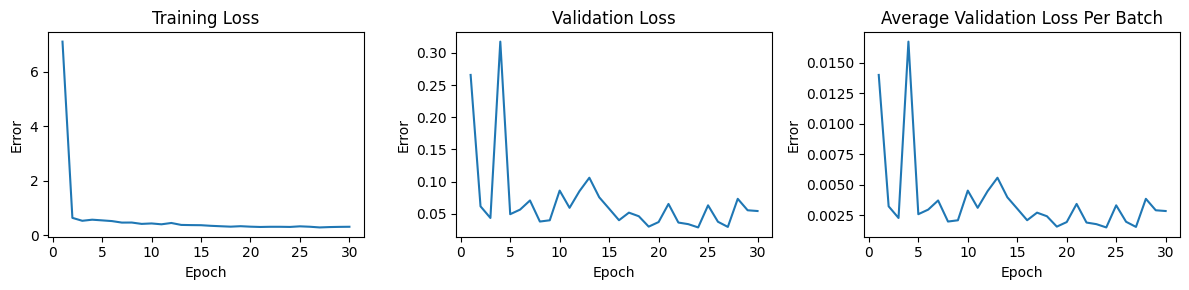

In [ ]:
plot_errors(training_loss, valid_loss, avg_valid_loss)

We will now see the model's performance on predicting on the Toronto's General dataset. The function below is for inferring future dates given the model and dataframe.

In [ ]:
def infer_date_(model, df, scaler, n_future, future_days = None, one_hot_feature = None):

    #Set model training to False
    model.train(False)
    copy_df = dc(df)

    #Case 1: if model predicts multiple days at once
    if n_future > 1:

        #Build Dateframe for future days
        max_date = df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date, end=max_date + pd.Timedelta(days=n_future), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Scaling input Dataframe
        copy_df.set_index('OCCUPANCY_DATE', inplace = True)
        df_scaled = scaler.fit_transform(copy_df)

        if one_hot_feature is not None:
            for i in range(one_hot_feature[1]):

                if i != one_hot_feature[0]:
                    arr = np.zeros((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))
                else:
                    arr = np.ones((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))

        #Convert data to tensor and passing it into the model to get predicted data and converting it into a panda dataframe before returning it
        y = model(torch.tensor(df_scaled).unsqueeze(0).float()).detach().numpy().reshape(-1,1)
        y_ = np.repeat(y, copy_df.shape[1], axis = -1)
        y_actual = scaler.inverse_transform(y_)[:,-1]
        y_inserted = np.insert(y_actual, 0, df['OCCUPIED_PERCENTAGE'].iloc[-1])
        df_new['OCCUPIED_PERCENTAGE'] = pd.DataFrame(y_inserted, columns = ['OCCUPIED_PERCENTAGE'])


    #Case 2: if model predicts one day at a time; therefore need loop to predict all future_days days.
    if n_future == 1 and future_days is not None:

        data = torch.tensor(scaler.fit_transform(np.array(copy_df['OCCUPIED_PERCENTAGE']).reshape(-1, 1)).reshape((-1, copy_df.shape[0], 1))).float()
        for i in range(future_days):
            y = model(data).unsqueeze(0)
            data = torch.cat((data, y), dim = 1)
        data = scaler.inverse_transform(data.squeeze().detach().numpy().reshape(-1, 1)).flatten()

        #Adding a data column to the new data
        max_date = copy_df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date , end=max_date + pd.Timedelta(days=future_days), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Getting the newly generated portion of data
        new_data = data[-future_days:]
        new_data = np.insert(new_data, 0, copy_df['OCCUPIED_PERCENTAGE'].iloc[-1])
        new_data_df = pd.DataFrame(new_data, columns = ['OCCUPIED_PERCENTAGE'])

        #Combined
        df_new['OCCUPIED_PERCENTAGE'] = new_data_df

    return df_new

The function below that is to create the graph itself

In [ ]:
def plot_general(model, df, n_future, scaler, test_check = False, future_days = None):

  #Deep copying the dataframe
  copy_df = dc(df)

  #If test check, move the data back by n_future days inorder to view model's performance
  if test_check:

    if future_days is None:
      use_date = max(copy_df['OCCUPANCY_DATE']) - pd.Timedelta(days = n_future)
      copy_df = copy_df[copy_df['OCCUPANCY_DATE'] <= use_date]

    elif future_days is not None:
      use_date = max(copy_df['OCCUPANCY_DATE']) - pd.Timedelta(days = future_days)
      copy_df = copy_df[copy_df['OCCUPANCY_DATE'] <= use_date]

  #Getting the inferred data
  data_frame = infer_date_(model, copy_df, scaler,n_future, future_days)

  plt.plot(df['OCCUPANCY_DATE'], df['OCCUPIED_PERCENTAGE'], label='Actual')
  plt.plot(data_frame['OCCUPANCY_DATE'], data_frame['OCCUPIED_PERCENTAGE'], label='Predicted')
  plt.title('All Shelters Occupancy Rates')
  plt.xlabel('Date')
  plt.ylabel('Occupied Percentage (%)')
  plt.legend()
  plt.show()

Calling the function to get the model's graph. We have asked the model to predict 60 days.

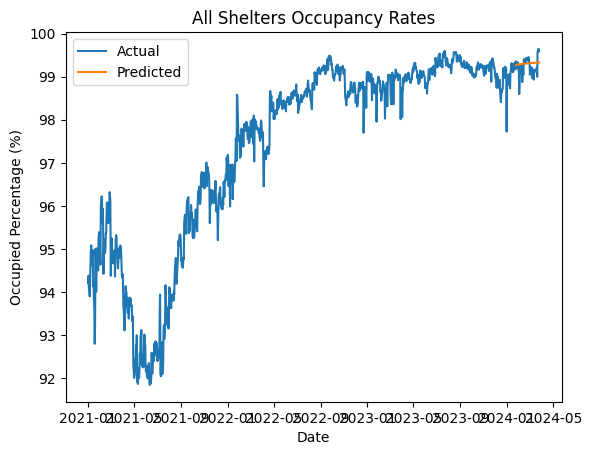

In [ ]:
test_check = True
df = df[used_features]
plot_general(model, df, n_future, scaler, test_check, future_days = 60)

Another method of visual inspection is that we will be using the model to infer data on 9 random shelters. The function belows achieves that.

In [ ]:
def plot_random_shelters(model, iso_data, n_future, num_sq, scaler, used_features, test_check = False, future_days = None):

	random_keys = random.sample(list(iso_data), num_sq ** 2)
	fig, axs = plt.subplots(num_sq, num_sq, figsize=(11, 8))
	for i in range(num_sq):
		for j in range(num_sq):

			shelter_index = random_keys[i * num_sq + j]  # Calculate the index from the 1D array

			#Preprocess the iso by copying it into local variables to avoid changing the iso_data itself
			df_use = dc(iso_data[shelter_index])
			max_date = df_use['OCCUPANCY_DATE'].max()

			if df_use['OCCUPANCY_RATE_ROOMS'].isna().all():
				df_use = df_use.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
			else:
				df_use = df_use.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

			df_infer = df_use[used_features]

			#If test check, move the data back by n_future days inorder to view model's performance
			if test_check:

				if future_days is None:
					use_date = max(df_use['OCCUPANCY_DATE']) - pd.Timedelta(days = n_future)
					df_infer = df_infer[df_infer['OCCUPANCY_DATE'] <= use_date]

				elif future_days is not None:
					use_date = max(df_use['OCCUPANCY_DATE']) - pd.Timedelta(days = future_days)
					df_infer = df_infer[df_infer['OCCUPANCY_DATE'] <= use_date]

			try:
				df = infer_date_(model, df_infer, scaler, n_future, future_days)

				axs[i, j].plot(df_use['OCCUPANCY_DATE'], df_use['OCCUPIED_PERCENTAGE'])
				axs[i, j].plot(df['OCCUPANCY_DATE'], df['OCCUPIED_PERCENTAGE'])

				#Labeling
				axs[i, j].set_title(f'Shelter {shelter_index}')
				axs[i, j].set_xlabel('Date')
				axs[i, j].set_ylabel('Occupied Percentage (%)')

			except Exception as e:
				print("Error: " + str(e))

	plt.tight_layout()
	plt.show()

Before we call the function, we will need to eliminate any incompatible shelters.

In [ ]:
for i in iso_data.copy():
  if iso_data[i].shape[0] <= n_steps - 1:
    del iso_data[i]

Calling this function to get the graph showing inference on random shelters

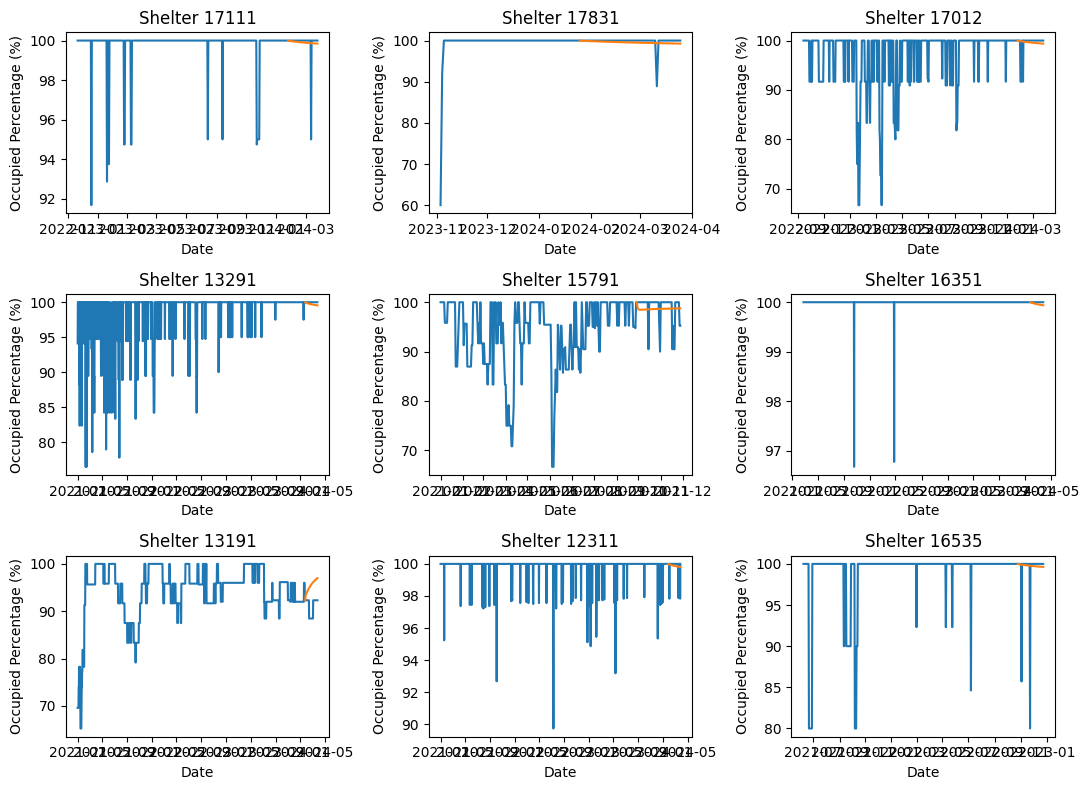

In [ ]:
test_check = True
num_sq = 3
plot_random_shelters(model, iso_data, n_future, num_sq, scaler, used_features, test_check, future_days = 60)

One last step is to run inference over 5 shelters and calculate the average error per shelter as a quality metric for other lstm implementations. The 5 shelters being used for testing are 11794, 11831, 12252, 12254, 12274.

In [ ]:
#Reduce iso_data to just the 5 shelters being used for testing
shelters_test = [11794, 11831, 12252, 12254, 12274]
for i in iso_data.copy():
  if i not in shelters_test:
    del iso_data[i]

#Initialize the Loss variables
total_shel = 0
total_shel_ = 0
loss_ = 0
loss_square = 0

for i in iso_data:

  if len(iso_data[i]) > 60:
    df = iso_data[i]

    #Rename the columns
    if df['OCCUPANCY_RATE_ROOMS'].isna().all():
      df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
    else:
      df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

    #Selecting on used features
    df = df[used_features]

    #Move the dates back by 60 days
    df_use_infer = dc(df)
    use_date = max(df_use_infer['OCCUPANCY_DATE']) - pd.Timedelta(days = 60)
    df_use_infer = df_use_infer[df_use_infer['OCCUPANCY_DATE'] <= use_date]

    #Inferring Data
    df_infer = infer_date_(model, df_use_infer, scaler, n_future, future_days = 60, one_hot_feature = None)
    df_infer_date = min(df_infer['OCCUPANCY_DATE'])
    df_infer = df_infer[df_infer['OCCUPANCY_DATE'] > df_infer_date]

    #data used for loss calculations
    df_loss = dc(df)
    df_loss = df_loss[df_loss['OCCUPANCY_DATE'] > use_date]

    #Calculating Loss
    df_np = df_loss['OCCUPIED_PERCENTAGE'].values
    df_np_infer = df_infer['OCCUPIED_PERCENTAGE'].values

    temp_loss = 0
    temp_loss_sq = 0
    for i in range(len(df_np)):
      temp_loss += abs(df_np[i] - df_np_infer[i])
      temp_loss_sq += abs(df_np[i] - df_np_infer[i]) ** 2
    if temp_loss > 0:
      total_shel += 1
      loss_ += temp_loss / 60
    if temp_loss_sq > 0:
      total_shel_ += 1
      loss_square += (temp_loss_sq / 60) ** (1/2)

avg_loss = loss_/total_shel
avg_loss_sq = loss_square/total_shel_
print("Average Loss per shelter is " + str(avg_loss))
print("Average Root Mean Square Loss per shelter is " + str(avg_loss_sq))

Average Loss per shelter is 1.4547850311279296
Average Root Mean Square Loss per shelter is 1.8243429508251574
